In [74]:

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

from xgboost import XGBRegressor 
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam
warnings.filterwarnings('ignore')

In [75]:
data=pd.read_csv('univariate_models/multivar.csv', index_col=0, parse_dates=[0])
data= data.set_index('date')
print(data.shape)
data = pd.get_dummies(data)

# Sort the DataFrame by the 'date' column
data = data.sort_values(by='date')
train_size = int(len(data) * 0.8)
train=data.iloc[:train_size ] 
test=data.iloc[train_size: ] 
print(train.shape, test.shape)
data.head()

(2023, 52)
(1618, 77) (405, 77)


,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,location_Israel,location_Italy,location_Malaysia,location_United States,tests_units_people tested,tests_units_tests performed,season_Autumn,season_Spring,season_Summer,season_Winter
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,True,False,True,False,False
2020-03-01,16.0,0.0,0.0,0.248,0.000,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
2020-03-01,NaN,0.0,0.0,NaN,0.000,NaN,NaN,0.395,2.372,NaN,...,False,False,False,False,False,False,False,True,False,False
2020-03-01,NaN,0.0,0.0,NaN,0.000,0.0,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
2020-03-01,15.0,5.0,0.0,1.587,0.529,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,True,False,False,True,False,False


In [76]:
metrics_df = pd.DataFrame(columns=['Model','mae','MAPE'])
metrics_df

,Model,mae,MAPE


In [77]:
data.dtypes

total_cases                    float64
new_cases                      float64
new_deaths                     float64
total_cases_per_million        float64
new_cases_per_million          float64
                                ...   
tests_units_tests performed       bool
season_Autumn                     bool
season_Spring                     bool
season_Summer                     bool
season_Winter                     bool
Length: 77, dtype: object

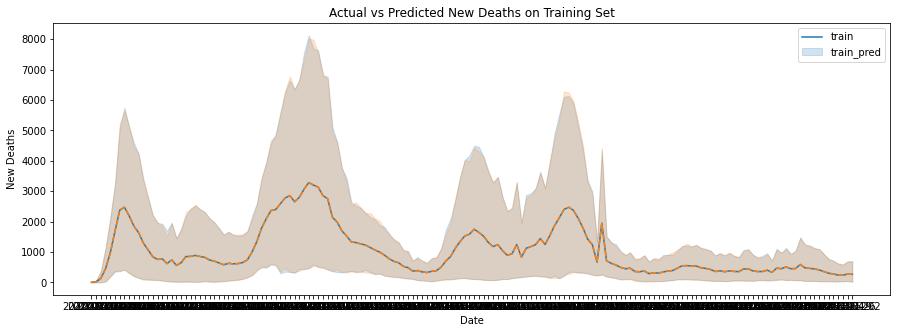

In [78]:
# Create XGBoost model
model = xgb.XGBRegressor()

# Fit the model on the training data
X_train = train.drop('new_deaths', axis=1)
y_train = train['new_deaths']
model.fit(X_train, y_train)

# Predict on the training set
train_pred = pd.DataFrame(model.predict(X_train), columns=['yhat'], index=train.index)

# Plot the actual vs predicted values
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([train['new_deaths'], train_pred['yhat']], axis=1))
plt.legend(['train', 'train_pred'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Training Set')
plt.show()

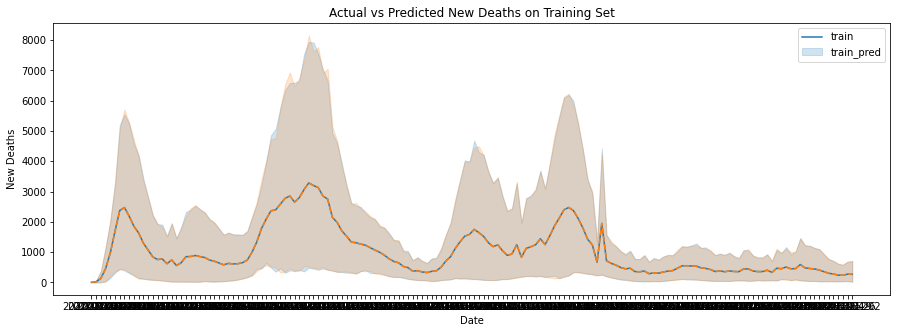

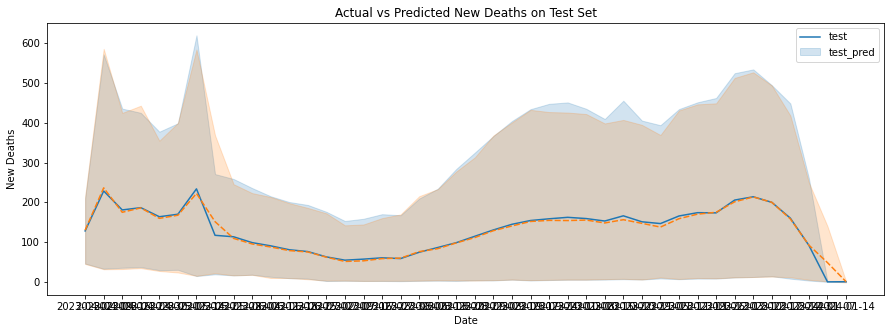

In [79]:
train_pred = pd.DataFrame(model.predict(X_train), columns=['yhat'], index=train.index)

# Plot the actual vs predicted values for training set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([train['new_deaths'], train_pred['yhat']], axis=1))
plt.legend(['train', 'train_pred'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Training Set')
plt.show()

# Predict on the test set
X_test = test.drop('new_deaths', axis=1)
y_test = test['new_deaths']
test_pred = pd.DataFrame(model.predict(X_test), columns=['yhat'], index=test.index)

# Plot the actual vs predicted values for test set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([test['new_deaths'], test_pred['yhat']], axis=1))
plt.legend(['test', 'test_pred'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Test Set')
plt.show()

In [80]:
actuals = test['new_deaths'] + 1
predictions = test_pred['yhat'] + 1
mape = mean_absolute_percentage_error(actuals, predictions) * 100
mae = mean_absolute_error(actuals, predictions)

metrics_df.loc[len(metrics_df)] = ['base xgb',mae, mape]

In [81]:
metrics_df

,Model,mae,MAPE
0,base xgb,7.759172,153.679716


In [82]:
import optuna
import sklearn.datasets
import sklearn.metrics

In [83]:


def objective(trial):

    param = {
        'objective': 'reg:squarederror',  # Assuming it's a regression task
        'eval_metric': 'mae',  # Using Mean Absolute Error as the evaluation metric
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
   
    }

    bst = xgb.train(param, xgb.DMatrix(train.drop('new_deaths', axis=1), label=train['new_deaths']))
    preds = bst.predict(xgb.DMatrix(test.drop('new_deaths', axis=1)))
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.mean_absolute_error(test['new_deaths'], pred_labels)
    return accuracy

study = optuna.create_study(direction='minimize')  # Use 'minimize' for Mean Absolute Percentage Error
study.optimize(objective, n_trials=10)

# Access the best parameters
best_params = study.best_params
print("Best Params:", best_params)


[I 2024-02-29 09:16:26,035] A new study created in memory with name: no-name-118221b8-75d2-4979-b6c9-8d0c86b7e6a6


[I 2024-02-29 09:16:26,220] Trial 0 finished with value: 42.10123456790124 and parameters: {'n_estimators': 281, 'learning_rate': 0.11698629175566119, 'max_depth': 10}. Best is trial 0 with value: 42.10123456790124.
[I 2024-02-29 09:16:26,281] Trial 1 finished with value: 60.501234567901236 and parameters: {'n_estimators': 203, 'learning_rate': 0.22887343344284788, 'max_depth': 3}. Best is trial 0 with value: 42.10123456790124.


[09:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-29 09:16:26,350] Trial 2 finished with value: 62.888888888888886 and parameters: {'n_estimators': 126, 'learning_rate': 0.34340265483320015, 'max_depth': 3}. Best is trial 0 with value: 42.10123456790124.
[I 2024-02-29 09:16:26,397] Trial 3 finished with value: 63.237037037037034 and parameters: {'n_estimators': 56, 'learning_rate': 0.2640646989626819, 'max_depth': 3}. Best is trial 0 with value: 42.10123456790124.
[I 2024-02-29 09:16:26,455] Trial 4 finished with value: 78.70864197530864 and parameters: {'n_estimators': 289, 'learning_rate': 0.13115156121945323, 'max_depth': 3}. Best is trial 0 with value: 42.10123456790124.


[09:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-29 09:16:26,535] Trial 5 finished with value: 50.41728395061728 and parameters: {'n_estimators': 285, 'learning_rate': 0.24521402091426447, 'max_depth': 3}. Best is trial 0 with value: 42.10123456790124.
[I 2024-02-29 09:16:26,639] Trial 6 finished with value: 32.35308641975308 and parameters: {'n_estimators': 197, 'learning_rate': 0.14049873557465886, 'max_depth': 7}. Best is trial 6 with value: 32.35308641975308.
[I 2024-02-29 09:16:26,709] Trial 7 finished with value: 14.77283950617284 and parameters: {'n_estimators': 295, 'learning_rate': 0.3498690583738745, 'max_depth': 5}. Best is trial 7 with value: 14.77283950617284.


[09:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-29 09:16:26,884] Trial 8 finished with value: 14.320987654320987 and parameters: {'n_estimators': 273, 'learning_rate': 0.23095699800813854, 'max_depth': 8}. Best is trial 8 with value: 14.320987654320987.
[I 2024-02-29 09:16:26,947] Trial 9 finished with value: 88.30123456790123 and parameters: {'n_estimators': 136, 'learning_rate': 0.10750600972119322, 'max_depth': 3}. Best is trial 8 with value: 14.320987654320987.


[09:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Best Params: {'n_estimators': 273, 'learning_rate': 0.23095699800813854, 'max_depth': 8}


In [84]:
model = xgb.XGBRegressor(n_estimators = 65, learning_rate = 0.3210929352407252, max_depth = 10)
model.fit(train.drop('new_deaths', axis=1), train['new_deaths']);

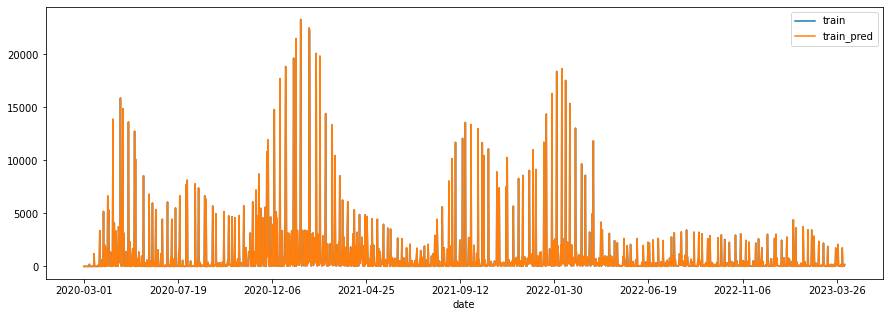

In [85]:
train_pred=pd.DataFrame(model.predict(train.drop('new_deaths', axis=1)), columns=['yhat'], index=train.index)
train_pred.head()
pd.concat([train['new_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

<Figure size 1080x720 with 0 Axes>

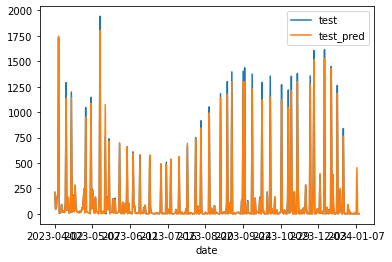

In [86]:
test_pred=pd.DataFrame(model.predict(test.drop('new_deaths', axis=1)), columns=['yhat'], index=test.index)
plt.figure(figsize=(15, 10))
pd.concat([test['new_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [87]:
test_pred

,yhat
date,
2023-04-02,212.238846
2023-04-02,45.536182
2023-04-09,52.380371
2023-04-09,169.841690
2023-04-09,201.076065
...,...
2024-01-07,-0.335079
2024-01-07,453.576691
2024-01-14,-0.042091


In [88]:
import pandas as pd
actuals = test['new_deaths'] + 1
predictions = test_pred['yhat'] + 1
mape = mean_absolute_percentage_error(actuals, predictions) * 100
mae = mean_absolute_error(actuals, predictions)
row = {'Model': 'xgb with tuning 1', 'mae': mae,'MAPE': mape}
metrics_df.loc[len(metrics_df)] = row

In [89]:
metrics_df

,Model,mae,MAPE
0,base xgb,7.759172,153.679716
1,xgb with tuning 1,10.435996,145.642603


In [90]:
import optuna 

# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'reg:squarederror',  # Assuming it's a regression task
        'eval_metric': 'mae',  # Using Mean Absolute Error as the evaluation metric
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }

    # Train the XGBoost model
    bst = xgb.train(param, xgb.DMatrix(train.drop('new_deaths', axis=1), label=train['new_deaths']))
    
    # Predict on the test set
    preds = bst.predict(xgb.DMatrix(test.drop('new_deaths', axis=1)))
    pred_labels = np.rint(preds)
    
    # Calculate Mean Absolute Error
    accuracy = sklearn.metrics.mean_absolute_error(test['new_deaths'], pred_labels)
    
    return accuracy


study = optuna.create_study(direction='minimize')  # Use 'minimize' for Mean Absolute Percentage Error
study.optimize(objective, n_trials=10)

# Access the best parameters
best_params = study.best_params
print("Best Params:", best_params)




[I 2024-02-29 09:16:28,329] A new study created in memory with name: no-name-cef31616-4d57-4ac4-9148-4f27b70bd618


[I 2024-02-29 09:16:28,564] Trial 0 finished with value: 13.162962962962963 and parameters: {'n_estimators': 214, 'learning_rate': 0.46467409887803546, 'max_depth': 10}. Best is trial 0 with value: 13.162962962962963.


[09:16:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-29 09:16:28,711] Trial 1 finished with value: 20.659259259259258 and parameters: {'n_estimators': 58, 'learning_rate': 0.19802170112244785, 'max_depth': 8}. Best is trial 0 with value: 13.162962962962963.
[I 2024-02-29 09:16:28,804] Trial 2 finished with value: 38.08395061728395 and parameters: {'n_estimators': 233, 'learning_rate': 0.1261254975779266, 'max_depth': 7}. Best is trial 0 with value: 13.162962962962963.
[I 2024-02-29 09:16:28,877] Trial 3 finished with value: 11.65679012345679 and parameters: {'n_estimators': 285, 'learning_rate': 0.34680502509459954, 'max_depth': 6}. Best is trial 3 with value: 11.65679012345679.


[09:16:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-29 09:16:29,018] Trial 4 finished with value: 53.49135802469136 and parameters: {'n_estimators': 197, 'learning_rate': 0.2039844536567359, 'max_depth': 3}. Best is trial 3 with value: 11.65679012345679.
[I 2024-02-29 09:16:29,225] Trial 5 finished with value: 11.291358024691357 and parameters: {'n_estimators': 262, 'learning_rate': 0.32778345272202036, 'max_depth': 9}. Best is trial 5 with value: 11.291358024691357.


[09:16:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-29 09:16:29,404] Trial 6 finished with value: 10.762962962962963 and parameters: {'n_estimators': 283, 'learning_rate': 0.3629226727501926, 'max_depth': 8}. Best is trial 6 with value: 10.762962962962963.


[09:16:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-29 09:16:29,503] Trial 7 finished with value: 14.819753086419754 and parameters: {'n_estimators': 275, 'learning_rate': 0.2787875200428365, 'max_depth': 5}. Best is trial 6 with value: 10.762962962962963.
[I 2024-02-29 09:16:29,611] Trial 8 finished with value: 14.669135802469135 and parameters: {'n_estimators': 60, 'learning_rate': 0.3294880746189706, 'max_depth': 5}. Best is trial 6 with value: 10.762962962962963.


[09:16:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:16:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-29 09:16:29,866] Trial 9 finished with value: 12.74320987654321 and parameters: {'n_estimators': 56, 'learning_rate': 0.2944596594549596, 'max_depth': 10}. Best is trial 6 with value: 10.762962962962963.


Best Params: {'n_estimators': 283, 'learning_rate': 0.3629226727501926, 'max_depth': 8}


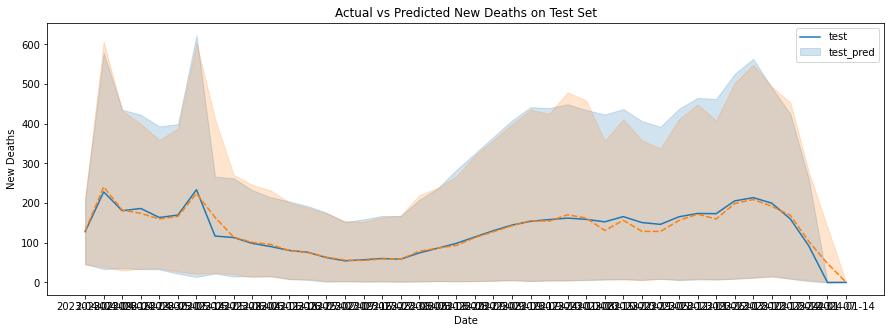

In [91]:
# Train the final XGBoost model with the best parameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(train.drop('new_deaths', axis=1), train['new_deaths'])

# Predict on the test set using the final model
test_preds = final_model.predict(test.drop('new_deaths', axis=1))
test_pred_labels = np.rint(test_preds)

# Plot the actual vs predicted values for the test set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([test['new_deaths'], pd.Series(test_pred_labels, index=test.index)], axis=1))
plt.legend(['test', 'test_pred'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Test Set')
plt.show()

In [92]:
import pandas as pd
actuals = test['new_deaths'] + 1
predictions = test_preds + 1
mape = mean_absolute_percentage_error(actuals, predictions) * 100
mae = mean_absolute_error(actuals,predictions)
row = {'Model': 'xgb with tuning 2','mae' : mae, 'MAPE': mape}
metrics_df.loc[len(metrics_df)] = row
print(mean_absolute_error(actuals,predictions))

9.34072556760576


In [93]:
metrics_df

,Model,mae,MAPE
0,base xgb,7.759172,153.679716
1,xgb with tuning 1,10.435996,145.642603
2,xgb with tuning 2,9.340726,156.825026
